# Анализ данных в Python

# Генеральная совокупность и выборка. Описательные статистики. Z-оценки. Выбросы.

<hr>

*Автор: Анастасия Волкова*

Приблизительное время самостоятельного изучения: **120** минут

## Подготовка

Для освоения данного материала предполагается, что уже просмотрены следующие разделы онлайн-курса

*   Генеральная совокупность и выборка. Частотные таблицы и распределения
*   Описательные статистики: меры центральной тенденции и разброса
*   Z-оценка. Выбросы

<h2>Содержание</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
<ol>
    <li><a>Генеральная совокупность и выборка</a>
    <li><a>Частотные таблицы</a></li>
    <li><a>Описательные статистики</a></li>
    <li><a>Z-оценка</a></li>
    <li><a>Выбросы</a></li>
</ol>

</div>
<hr>

<h2>Библиотеки и данные</h2>

In [1]:
import numpy as np                 # числовые данные
import pandas as pd                # таблицы

import matplotlib.pyplot as plt    # графики
import seaborn as sns              # продвинутые графики

from scipy.stats import norm       # нормальное распределение
from scipy import stats            # стандартизированная оценка

import warnings                    # отключение уведомлений
warnings.filterwarnings("ignore")

<h3> Данные по покупкам в Стамбуле </h3>

*Источник: <a href="https://www.kaggle.com/datasets/mehmettahiraslan/customer-shopping-dataset">**kaggle.com**</a>*

* **Данные**: покупки в 10 торговых центрах Стамбула
* **Единицы измерения**: TL, турецкие лиры
* **Период**: 2021-2023

**Переменные:**

| Название       |      Формат       |    Значение     |
| :------------  | :---------------  | :-------------- |
| invoice_no     |    номинальная    |  уникальный код покупки |
| customer_id    |    номинальная    |  уникальный номер покупателя |
| gender         |    бинарная       | пол покупателя |
| age            |    числовая       |   возраст покупателя |
| category       |    номинальная    |   категория товаров |
| quantity       |     числовая      |  количество товара |
| price          |     числовая      |  цена одной единицы |
| payment_method |     номинальная   | способ платежа |
| invoice_date   |     номинальная   | способ платежа |
| shopping_mall  |     номинальная   | название торгового центра |


In [2]:
# загружаем датасет и проверяем адекватность таблицы

df_original = pd.read_csv('customer_shopping_data.csv')
df_original.head()

# ссылка на данные https://raw.githubusercontent.com/aaparshina/22-23_Intro-to-DS/main/DATA/customer_shopping_data.csv

,invoice_no,customer_id,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall
0,I138884,C241288,Female,28,Clothing,5,1500.40,Credit Card,5/8/2022,Kanyon
1,I317333,C111565,Male,21,Shoes,3,1800.51,Debit Card,12/12/2021,Forum Istanbul
2,I127801,C266599,Male,20,Clothing,1,300.08,Cash,9/11/2021,Metrocity
3,I173702,C988172,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM
4,I337046,C189076,Female,53,Books,4,60.60,Cash,24/10/2021,Kanyon


In [3]:
# делаем копию и далее работаем только с ней

df = df_original.copy()

In [4]:
# пропусков нет

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99457 entries, 0 to 99456
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   invoice_no      99457 non-null  object 
 1   customer_id     99457 non-null  object 
 2   gender          99457 non-null  object 
 3   age             99457 non-null  int64  
 4   category        99457 non-null  object 
 5   quantity        99457 non-null  int64  
 6   price           99457 non-null  float64
 7   payment_method  99457 non-null  object 
 8   invoice_date    99457 non-null  object 
 9   shopping_mall   99457 non-null  object 
dtypes: float64(1), int64(2), object(7)
memory usage: 7.6+ MB


In [5]:
# удалим переменные с уникальными кодами покупки/покупателя
# для агрегированного анализа они не несут ценности

df.drop(['invoice_no', 'customer_id'], axis = 1, inplace = True)

<h2>Первичный анализ данных</h2>

<div class="alert alert-block alert-info" style="margin-top: 20px">
    
Представим, что **задача аналитика** изучить особенности потребления различных товаров в Стамбуле.
    
Что в данном случае будет являться **генеральной совокупностью**, а что **выборкой**?
</div>



<hr> 

*Вспомним определения из онлайн-курса:*

**Генеральная совокупность** — это совокупность всех объектов, которые представляют интерес в конкретном исследовании.

**Выборка** — это группа объектов, отобранных из генеральной совокупности для исследования.

**Репрезентативность** — соответствие характеристик выборки характеристикам генеральной совокупности.

<hr>

<div class="alert alert-block alert-info" style="margin-top: 5px">
    
Можно ли считать данную выборку **репрезентативной**?
    
</div>


1. Данные о скольких покупках доступны в выборке?

<code>dataframe.shape</code> - (кол-во строк, кол-во столбцов)


In [6]:
df.shape[0]

99457

**Почти 100 тысяч покупок. Много или мало?**

Учитывая, что население Стамбула более 15 млн жителей, не считая туристов, это, конечно, не много за 2 года.

Однако важно не только это.

2. Нужно посмотреть где были сделаны эти покупки.

Если в одном магазине, то это позволит сделать выводы только для аудитории данного магазина.

<code>dataframe['column_name'].unique()</code> - метод получения уникальных записей

In [7]:
# список уникальных торговых центров, присутствующих в выборке

df['shopping_mall'].unique()

array(['Kanyon', 'Forum Istanbul', 'Metrocity', 'Metropol AVM',
       'Istinye Park', 'Mall of Istanbul', 'Emaar Square Mall',
       'Cevahir AVM', 'Viaport Outlet', 'Zorlu Center'], dtype=object)

<code>dataframe['column_name'].value_counts()</code> - количество повторений уникальных записей

In [8]:
# равномерность распределения покупок по торговым центрам

df['shopping_mall'].value_counts()

Mall of Istanbul     19943
Kanyon               19823
Metrocity            15011
Metropol AVM         10161
Istinye Park          9781
Zorlu Center          5075
Cevahir AVM           4991
Forum Istanbul        4947
Viaport Outlet        4914
Emaar Square Mall     4811
Name: shopping_mall, dtype: int64

**10 достаточно больших торговых центров - вполне репрезентативно.**

3. Теперь нужно оценить половозрастной состав покупателей.

In [9]:
# соотношение покупателей мужчин и женщин

df.gender.value_counts()

Female    59482
Male      39975
Name: gender, dtype: int64

На первый взгляд вполне репрезентативно, но можно посчитать и процентное соотношение.

In [10]:
# YOUR CODE

Теперь посмотрим на **возраст покупателей**

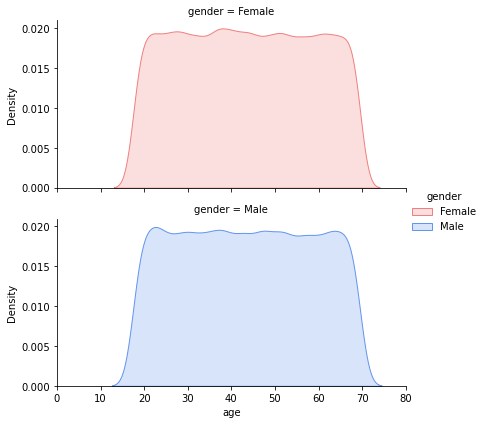

In [11]:
# учиться рисовать графики будем на следующих семинарах
# пока просто смотрим и анализируем

pal = dict(Male = '#6495ED',
         Female = '#F08080')

g = sns.FacetGrid(df, row="gender", hue="gender", aspect=2.0, palette=pal)

g.map(sns.kdeplot, "age", shade=True)
g.set(xlim=(0, 80), ylim=0)
g.add_legend();

Можно сказать, что выборка репрезентативна, так как распределение возраста покупателей выглядит равномерным.

Потренируемся в создании категорий 

**Binning**

Поделим покупателей на **3 группы по возрасту**: молодые, зрелые, пожилые.

Границы выберем произвольно.
Далее можно самостоятельно поэкспериментировать.

<code>np.linspace(start_value, end_value, numbers_generated)</code> - определяем шкалу как по линейке

<code>pd.cut(dataframe['column_name'], bins) </code> - распределяем данные по категориям

In [12]:
# список категорий
group_names = ['Young', 'Adult', 'Old']

# определим равномерные границы
bins = np.linspace(min(df['age']), max(df['age']), 4)

# создаем новую переменную age_category
df['age_category'] = pd.cut(df['age'], bins, labels=group_names, include_lowest=True)

# смотрим на баланс новых категорий
df['age_category'].value_counts()

Young    34418
Adult    32876
Old      32163
Name: age_category, dtype: int64

**Примерно равное соотношение. Этого и стоило ожидать, исходя из распределения выше.**

<div class="alert alert-block alert-info" style="margin-top: 20px">
Чтобы не сравнивать на глаз, каким образом можно формально описать (прокомментировать) имеющиеся данные?
    
Для этого воспользуемся стандартными **описательными статистиками**.
</div>

<h2>Описательные статистики</h2>

<hr> 

*Вспомним оcновные теоретические моменты:*

**Среднее значение**

Среднее не нуждается в представлении. 
Вычислить его довольно просто: сложите все значения определенного признака и разделите полученную сумму на их количество:

$$
\bar {x} =  \frac {1}{n} \sum _{i=1}^{n}x_{i}
$$

Среднее значение отражает типичный показатель в наборе данных: 
если мы случайно выберем любое значение признака, то, *скорее всего*, получим значение, близкое к среднему.

<code>dataframe['column_name'].mean()</code> - вычисление среднего

In [13]:
# средний возраст типичного покупателя

df['age'].mean()

43.42708909377922

<code>round(value_to_round, n_of_digits)</code> - округление до точного кол-ва знаков после запятой

In [14]:
# для красоты можно округлить
round(df['age'].mean(), 0)

43.0

Cреднее для мужчин и женщин по отдельности практически совпадает.

<code>dataframe.groupby('column_to_group')['column_name'].mean()</code> 

In [15]:
df.groupby('gender')['age'].mean()

gender
Female    43.453515
Male      43.387767
Name: age, dtype: float64

**Однако не всегда разумно вычислять именно среднее значение для получения адекватной картины.**

Это как вычислять среднюю температуру по больнице.

Жонглированием статистикой можно доказать самые разнообразные утверждения — важно лишь понимать цель использования. Часто в распределение включаются самые разнородные элементы, вычисление «среднего» по которым теряет всякий смысл. 
В таких случаях следует проводить кластеризацию — разбиение распределения на более-менее однородные по параметру усреднения группы.

Например, посчитаем среднюю цену товара из выборки.

In [16]:
df['price'].mean()

689.2563209223512

Теперь посмотрим на распределение данной переменной.

По оси Х - цена товара, Y - кол-во товаров по данной цене.

<AxesSubplot:xlabel='price', ylabel='Count'>

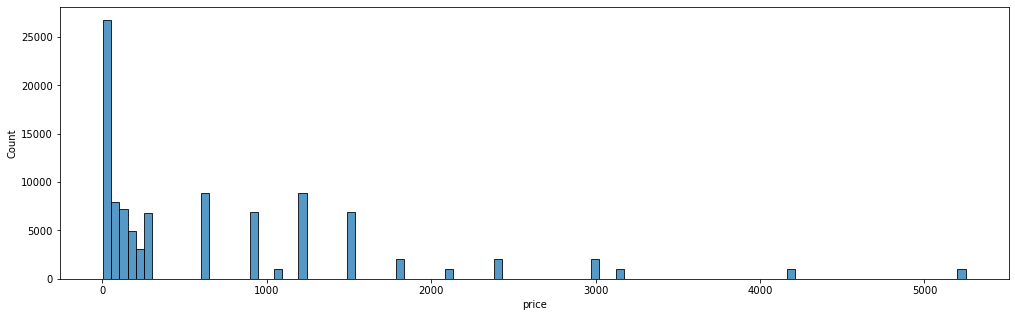

In [17]:
plt.figure(figsize=(17,5))
sns.histplot(data=df['price'])

В данном случае видим, что большинство товаров стоят менее 400 лир, поэтому среднее в 689 здесь явно нерепрезентативно.

Попробуем рассчитать медиану.

**Медиана**

Чтобы найти медиану, данные нужно расположить в порядке возрастания. Медианой будет значение, которое совпадает с серединой набора данных. Если количество значений чётное, то берётся среднее двух значений, которые «окружают» середину.

In [18]:
df['price'].median()

203.3

**Данное значение можно считать более репрезентативным.**

Для описания несимметрично распределенных величин чаще используется медиана.

Разницу можно проиллюстрировать примером с распределением доходов населения.

<a href="https://pikabu.ru/story/o_raspredelenii_dokhodov_rossiyan_5289242">*Пример*</a>


Изобразим наглядно на графике различие между средним и медианой.

**Запомним простое правило!**

*В какую сторону смещено распределение (где площадь больше) -
в ту же сторону смещается медиана относительно среднего.*

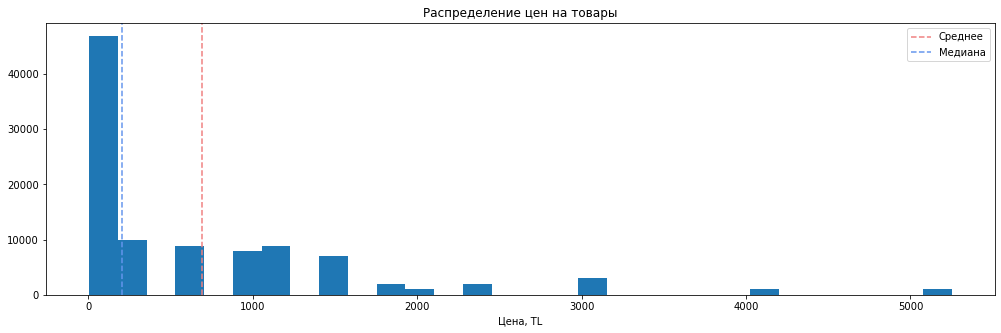

In [19]:
plt.figure(figsize=(17,5))
plt.hist(df['price'], bins=30)
plt.title('Распределение цен на товары')
plt.xlabel('Цена, TL')

mean = df['price'].mean() 
median = df['price'].median()  

plt.axvline(mean, linestyle='--', color='#F08080', label='Среднее')
plt.axvline(median, linestyle='--', color='#6495ED', label='Медиана')

plt.legend(loc='best')
plt.show()

В случае с идеально симметричными распределениями - среднее и медиана совпадают!

**Мода**

Это значение переменной с самой большой частотой, т.е. самое популярное значение переменной.

In [20]:
# самая популярная цена товара
df['price'].mode()

0    600.16
Name: price, dtype: float64

In [21]:
# самый популярный возраст покупателя
df['age'].mode()

0    37
Name: age, dtype: int64

Для переменной цены эта мера не особо полезна, так как цена - величина непрерывная, и самое популярное значение практически ни о чем не говорит.

Однако мода - **единственная возможная** описательная статистика для **номинальных** переменных!

Например, найдем самую популярную категорию товаров  *(это одежда)*

In [22]:
df['category'].mode()

0    Clothing
Name: category, dtype: object

Описательная таблица для номинальных переменных (кол-во всех/уникальных элементов + самый популярный) 

In [23]:
df.describe(include='object')

,gender,category,payment_method,invoice_date,shopping_mall
count,99457,99457,99457,99457,99457
unique,2,8,3,797,10
top,Female,Clothing,Cash,24/11/2021,Mall of Istanbul
freq,59482,34487,44447,159,19943


Общая описательная таблица

In [24]:
df.describe(include='all')

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,age_category
count,99457,99457.000000,99457,99457.000000,99457.000000,99457,99457,99457,99457
unique,2,NaN,8,NaN,NaN,3,797,10,3
top,Female,NaN,Clothing,NaN,NaN,Cash,24/11/2021,Mall of Istanbul,Young
freq,59482,NaN,34487,NaN,NaN,44447,159,19943,34418
mean,NaN,43.427089,NaN,3.003429,689.256321,NaN,NaN,NaN,NaN
std,NaN,14.990054,NaN,1.413025,941.184567,NaN,NaN,NaN,NaN
min,NaN,18.000000,NaN,1.000000,5.230000,NaN,NaN,NaN,NaN
25%,NaN,30.000000,NaN,2.000000,45.450000,NaN,NaN,NaN,NaN
50%,NaN,43.000000,NaN,3.000000,203.300000,NaN,NaN,NaN,NaN
75%,NaN,56.000000,NaN,4.000000,1200.320000,NaN,NaN,NaN,NaN


<hr> 

*Существуют некоторые закономерности:*

* В симметричном распределении с одной модой (унимодальном) все три меры будут более-менее совпадать.
* В симметричном распределении с более чем одной модой, медиана и среднее будут более-менее совпадать.
* Для положительно ассиметричного унимодального распределения (скошенного вправо) мода меньше медианы, а медиана меньше среднего.
* Для отрицательно ассиметричного унимодального распределения (скошенного влево) - наоборот.

<hr> 

**Теперь про квантили**

**Квантиль** - значение, которое заданная случайная величина не превышает с фиксированной вероятностью. 

Если вероятность задана в процентах, то квантиль называется процентилем или перцентилем.

*Например, фраза «для развитых стран 99-процентиль продолжительности жизни составляет 100 лет» означает, что ожидается, что 99% людей проживут не более 100 лет.*

**Квартили**  — это квантили, кратные 25%, то есть соответствующие 25%, 50% и 75% *(Q1, Q2 и Q3), (нижний, средний, верхний)* .

**Межквартильный размах (IQR)** — это разница между 1-м и 3-м квартилями, т.е. между 25-м и 75-м процентилями. 
В него входят центральные 50% наблюдений в упорядоченном наборе, где 25% наблюдений находятся ниже центральной точки и 25% — выше.

**Выбросы (outliers)** — экстремально маленькие или большие значения в выборке. 
Они могут достаточно сильно искажать картину при расчете описательных статистик и построении моделей, поэтому нужно чистить выборку от выбросов (удалять подобные наблюдения).

*Один из критериев экстремальности* - все, что не попадает в диапазон *(Q1 - 1.5 IQR, Q3 + 1.5 IQR)*

<center>
<img src="https://github.com/aaparshina/22-23_Intro-to-DS/blob/main/PICS/quartiles-and-outliers.png?raw=true" width="600" height="400">
</center>

*Источник картинки, а также наглядный пример расчета*
<a href="https://www.math.net/interquartile-range">*здесь*</a>

In [25]:
# пример вычисления межквартильного размаха (IQR) для переменной возраста

iqr = df['age'].quantile(0.75) - df['age'].quantile(0.25)
iqr

26.0

In [26]:
# кажется, что медиана и квантиль 50% - это одно и то же

df['age'].quantile(0.5) == df['age'].median()

True

Найдем выбросы по переменной цены товара

In [27]:
iqr = df['price'].quantile(0.75) - df['price'].quantile(0.25)

outliers = []

lower_bound = df['price'].quantile(0.25) - 1.5 * iqr
upper_bound = df['price'].quantile(0.75) + 1.5 * iqr

# убедимся, что циклы в таблицах - не самый удобный способ 
# далее не будем им пользоваться

for i in df.index:
    if df.iloc[i]['price'] > upper_bound or df.iloc[i]['price'] < lower_bound:
        outliers.append(df.iloc[i]['price'])
        
print(f'Всего выбросов в выборке: {len(outliers)}')

Всего выбросов в выборке: 5024


Слишком много выбросов, однако здесь нужно посмотреть более детально.

Найдем выбросы по цене в разрезе категорий товара.
Определим экстремально дешевые и дорогие товары в каждой из категорий

In [53]:
# группируем данные по категориям и выводим общую табличку с описательными статистиками
df_stat = df.groupby('category')['price'].describe()

df_stat['iqr'] = df_stat['75%'] - df_stat['25%']

df_stat['lower_bound'] = df_stat['25%'] - 1.5 * df_stat['iqr']
df_stat['upper_bound'] = df_stat['75%'] + 1.5 * df_stat['iqr']

# скорректируем нижнюю границу из отрицательных значений до нуля
df_stat['lower_bound'] = np.where(df_stat['lower_bound'] < 0, 0, df_stat['lower_bound'])

# проверим есть ли вхоть один выброс по верхней границе
df_stat['any_outlier'] = np.where(df_stat['max'] - df_stat['upper_bound'] > 0, 'yes', 'no')

# наличие выбросов по максимальному значению
df_stat

,count,mean,std,min,25%,50%,75%,max,iqr,lower_bound,upper_bound,any_outlier
category,,,,,,,,,,,,
Books,4981.0,45.568621,21.492662,15.15,30.30,45.45,60.60,75.75,30.30,0.0,106.05,no
Clothing,34487.0,901.084021,424.225594,300.08,600.16,900.24,1200.32,1500.40,600.16,0.0,2100.56,no
Cosmetics,15097.0,122.448626,57.458097,40.66,81.32,121.98,162.64,203.30,81.32,0.0,284.62,no
Food & Beverage,14776.0,15.671948,7.422176,5.23,10.46,15.69,20.92,26.15,10.46,0.0,36.61,no
Shoes,10034.0,1807.388568,845.116269,600.17,1200.34,1800.51,2400.68,3000.85,1200.34,0.0,4201.19,no
Souvenir,4999.0,34.894345,16.564498,11.73,23.46,35.19,46.92,58.65,23.46,0.0,82.11,no
Technology,4996.0,3156.935548,1481.559805,1050.00,2100.00,3150.00,4200.00,5250.00,2100.00,0.0,7350.00,no
Toys,10087.0,107.733185,50.364844,35.84,71.68,107.52,143.36,179.20,71.68,0.0,250.88,no


По категориям выбросов нет, что очень приятно!

Посмотрим на тип графика, подходящий для иллюстрации наличия выбросов (ящик с усами, boxplot).

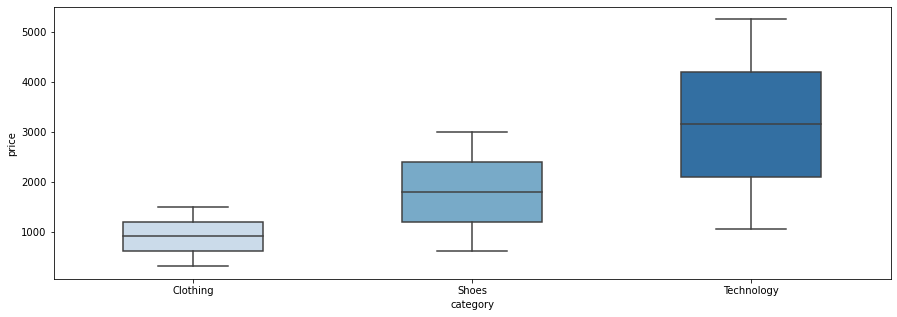

In [29]:
plt.figure(figsize=(15,5))
df_1 = df[df['category'].isin(('Clothing', 'Shoes', 'Technology'))]
sns.boxplot(x=df_1['category'], y=df_1['price'], palette="Blues", width=0.5)
plt.show()

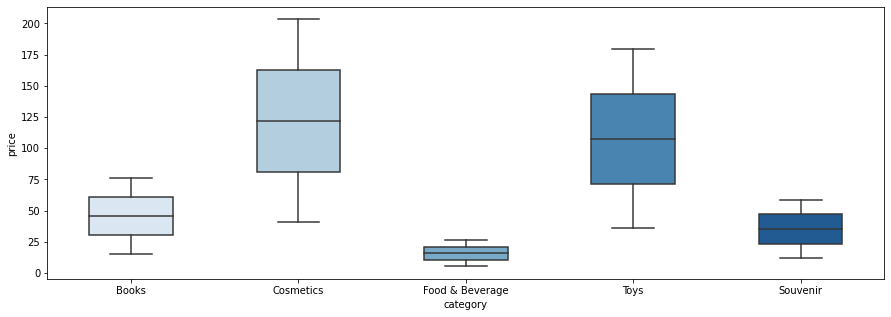

In [30]:
plt.figure(figsize=(15,5))
df_1 = df[~df['category'].isin(('Clothing', 'Shoes', 'Technology'))]
sns.boxplot(x=df_1['category'], y=df_1['price'], palette="Blues", width=0.5)
plt.show()

Действительно, выбросов нет!

<div class="alert alert-danger alertdanger">
<h1> Задание - Обязательное </h1>

Создайте новую переменную **сумма покупки = кол-во * цена товара**

Найдите количество выбросов по данной переменной.
Создайте новый датафрейм  **df_task_1** без данных наблюдений.

**Подсказка**

Удаляем строки с помощью команды 
<code>dataframe.drop(index, axis = 0, inplace = True)</code> 
    
**Спойлер**
    
Итеративно обрабатывать большие массивы данных достаточно долго.
Можно подумать как оптимизировать процесс.

</div>

In [31]:
# YOUR CODE

**Однако это не единственный способ определения выбросов**

Меры разброса также показывают, насколько хорошо данные значения представляют совокупность.

**Дисперсия и стандартное отклонение**

Давайте посмотрим на то, насколько цена товара отличается от средней по категории. 

Для этого будем брать цену $x_i$ и вычитать из нее среднее, $\bar x$:

$$
(x_i - \bar x)
$$

Укаазанная ниже величина называется *дисперсией*

$$
\sigma^2= \frac{1}{n} \sum_{i=1}^{n} (x_{i}-{\bar {x}})^{2}
$$

Проблема дисперсии в том, что она измеряется в квадратных единицах. 
Чтобы вернуться назад, к обычным единицам, нужно извлечь из неё корень. 
Тогда получится величина, которая называется *среднеквадратическим отклонением* или *стандартным отклонением*. 

**Более правильна формула** дисперсии со статистической точки зрения. Она зашита в статистические пакеты.

$$
\sigma^2= \frac{1}{n-1} \sum_{i=1}^{n} (x_{i}-{\bar {x}})^{2}
$$

In [32]:
# дисперсия
df.groupby('category')['price'].var()

category
Books              4.619345e+02
Clothing           1.799674e+05
Cosmetics          3.301433e+03
Food & Beverage    5.508869e+01
Shoes              7.142215e+05
Souvenir           2.743826e+02
Technology         2.195019e+06
Toys               2.536618e+03
Name: price, dtype: float64

In [33]:
# стандартное отклонение
df.groupby('category')['price'].std()

category
Books                21.492662
Clothing            424.225594
Cosmetics            57.458097
Food & Beverage       7.422176
Shoes               845.116269
Souvenir             16.564498
Technology         1481.559805
Toys                 50.364844
Name: price, dtype: float64

**Проинтерпретируйте** полученные результаты:

* В какой категории наблюдается наибольший и наименьший разброс и с чем это может быть связано?
* Предположите, в чем смысл сначала возводить отклонения в квадрат, а потом брать корень?

<div class="alert alert-danger alertdanger">
<h1> Задание - Полезное </h1>

Рассчитайте дисперсию по переменной цены товара вручную (без использования специальных команд).
    
Вспомним **Numerical Python**

</div>

In [34]:
# YOUR CODE

**Еще один способ выявления выбросов.**

Если мы знаем, что распределение значений в выборке является **гауссовским** или гауссовидным (симметричное, колоколообразное, нормальное), мы можем использовать стандартное отклонение выборки в качестве предела для выявления выбросов.

Три стандартных отклонения от среднего значения - это обычное ограничение на практике для выявления выбросов в нормальном распределении. 
Для небольших выборок данных может быть использовано значение 2 стандартных отклонения (95%), а для более крупных выборок может быть использовано значение 4 стандартных отклонения (99,9%).



<center>
<img src="https://github.com/aaparshina/22-23_Intro-to-DS/blob/main/PICS/Z-2_tailed.png?raw=true" width="400" height="200">
</center>

Распределение цен не похоже на нормальное, однако в учебных целях попробуем найти выбросы с помощью среднего и стандартного отклонения.

In [35]:
mean = df['price'].mean()
std = df['price'].std()

left_tail = mean - 2.0 * std
right_tail = mean + 2.0 * std

print(left_tail, right_tail, sep = '\n')

df[(df['price'] < left_tail) | (df['price'] > right_tail)]

-1193.112813509134
2571.625455353836


,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,age_category
3,Female,66,Shoes,5,3000.85,Credit Card,16/05/2021,Metropol AVM,Old
15,Male,24,Shoes,5,3000.85,Credit Card,7/11/2021,Viaport Outlet,Young
23,Male,44,Technology,5,5250.00,Cash,26/10/2021,Kanyon,Adult
53,Female,43,Technology,4,4200.00,Cash,22/02/2022,Metrocity,Adult
69,Female,44,Technology,5,5250.00,Credit Card,19/11/2021,Mall of Istanbul,Adult
...,...,...,...,...,...,...,...,...,...
99332,Female,53,Shoes,5,3000.85,Credit Card,13/03/2022,Metrocity,Old
99374,Male,36,Technology,3,3150.00,Credit Card,24/12/2021,Metropol AVM,Adult
99387,Male,33,Technology,3,3150.00,Credit Card,1/8/2022,Kanyon,Young
99424,Female,34,Technology,3,3150.00,Cash,13/01/2021,Metrocity,Young


И в разрезе категорий тоже

In [48]:
df_stat

,count,mean,std,min,25%,50%,75%,max,iqr,lower_bound,upper_bound,any_outlier,lb,ub,std_outlier
category,,,,,,,,,,,,,,,
Books,4981.0,45.568621,21.492662,15.15,30.30,45.45,60.60,75.75,30.30,0.0,106.05,no,2.583297,88.553945,no
Clothing,34487.0,901.084021,424.225594,300.08,600.16,900.24,1200.32,1500.40,600.16,0.0,2100.56,no,52.632834,1749.535208,no
Cosmetics,15097.0,122.448626,57.458097,40.66,81.32,121.98,162.64,203.30,81.32,0.0,284.62,no,7.532431,237.364820,no
Food & Beverage,14776.0,15.671948,7.422176,5.23,10.46,15.69,20.92,26.15,10.46,0.0,36.61,no,0.827597,30.516300,no
Shoes,10034.0,1807.388568,845.116269,600.17,1200.34,1800.51,2400.68,3000.85,1200.34,0.0,4201.19,no,117.156029,3497.621107,no
Souvenir,4999.0,34.894345,16.564498,11.73,23.46,35.19,46.92,58.65,23.46,0.0,82.11,no,1.765348,68.023341,no
Technology,4996.0,3156.935548,1481.559805,1050.00,2100.00,3150.00,4200.00,5250.00,2100.00,0.0,7350.00,no,193.815938,6120.055159,no
Toys,10087.0,107.733185,50.364844,35.84,71.68,107.52,143.36,179.20,71.68,0.0,250.88,no,7.003498,208.462873,no


In [55]:
df_stat['lb'] = df_stat['mean'] - 2.0 * df_stat['std']
df_stat['ub'] = df_stat['mean'] + 2.0 * df_stat['std']

# проверим есть ли хоть один выброс по верхней границе
df_stat['std_outlier'] = np.where(((df_stat['max'] - df_stat['ub'] > 0) | \
                                   (df_stat['min'] + df_stat['lb'] < 0)), 'yes', 'no')

# наличие выбросов по максимальному значению
df_stat

,count,mean,std,min,25%,50%,75%,max,iqr,lower_bound,upper_bound,any_outlier,lb,ub,std_outlier
category,,,,,,,,,,,,,,,
Books,4981.0,45.568621,21.492662,15.15,30.30,45.45,60.60,75.75,30.30,0.0,106.05,no,2.583297,88.553945,no
Clothing,34487.0,901.084021,424.225594,300.08,600.16,900.24,1200.32,1500.40,600.16,0.0,2100.56,no,52.632834,1749.535208,no
Cosmetics,15097.0,122.448626,57.458097,40.66,81.32,121.98,162.64,203.30,81.32,0.0,284.62,no,7.532431,237.364820,no
Food & Beverage,14776.0,15.671948,7.422176,5.23,10.46,15.69,20.92,26.15,10.46,0.0,36.61,no,0.827597,30.516300,no
Shoes,10034.0,1807.388568,845.116269,600.17,1200.34,1800.51,2400.68,3000.85,1200.34,0.0,4201.19,no,117.156029,3497.621107,no
Souvenir,4999.0,34.894345,16.564498,11.73,23.46,35.19,46.92,58.65,23.46,0.0,82.11,no,1.765348,68.023341,no
Technology,4996.0,3156.935548,1481.559805,1050.00,2100.00,3150.00,4200.00,5250.00,2100.00,0.0,7350.00,no,193.815938,6120.055159,no
Toys,10087.0,107.733185,50.364844,35.84,71.68,107.52,143.36,179.20,71.68,0.0,250.88,no,7.003498,208.462873,no


Результат тот же. В разрезе категорий выбросы не обнаружены.

**Стандартизованная оценка (Z-Score)**

<hr>

Стандартизованная оценка (Z-Score) – метрика, характеризующая удаленность наблюдения от среднего значения.
Иными словами, на сколько стандартных отклонений ниже или выше среднего находится наблюдение. 

Рассчитывается по формуле:
$$
Z = \frac{x_i - \bar x}{\sigma}
$$

Это способ сравнить результаты с «нормальной» частью совокупности. 

<div class="alert alert-danger alertdanger">
<h1> Задание - Очевидное </h1>

Рассчитайте по формуле выше **Z-Score** для каждого наблюдения.
    
Запишите пары  {возраст, Z-Score} в новый датафрейм. 
    
Удалите дубликаты с помощью <code>df.drop_duplicates(inplace = True)</code> и отсортируйте таблицу по возрасту
    
Прокомментируйте результат для покупателя 20, 40 лет и 60 лет. 
    
Для покупателя какого возраста Z-Score равен нулю?
    
Далее можно рассчитать Z-score с помощью команды <code>stats.zscore(df['column'])</code>.
    
Проверьте, что результаты совпадают.

</div>

In [37]:
# YOUR CODE

<div class="alert alert-block alert-info" style="margin-top: 5px">
    
**Must have изучен!**
    
</div>

Вернемся к анализу содержания датасета.

Нам доступна дата покупки *invoice_date*, однако она представлена в виде строки.

Для таких переменных есть специальный формат datetime.


In [38]:
# преобразуем переменную с датой
df['invoice_date'] = pd.to_datetime(df['invoice_date'], dayfirst = True)

Возвращаясь к теме репрезентативности, проанализируем сезонность покупок.

Если выборка была собрана в определенное время, это может привести к сезонным искажениям.

С datetime очень удобно делать преобразования и агрегации.

Создадим отдельные переменные для года, квартала, месяца и дня недели.

In [39]:
df['year'] = df['invoice_date'].dt.year

df['quarter'] = pd.PeriodIndex(df['invoice_date'], freq='Q')
df['quarter'] = df['quarter'].astype('string')

df['month'] = df['invoice_date'].dt.month

df['weekday'] = df['invoice_date'].dt.weekday

days_of_week = {
    0: 'Monday', 
    1: 'Tuesday', 
    2: 'Wednesday', 
    3: 'Thursday', 
    4: 'Friday',
    5: 'Saturday', 
    6: 'Sunday'
} 

df['weekday'] = df['invoice_date'].dt.weekday.map(days_of_week)

In [40]:
df.head()

,gender,age,category,quantity,price,payment_method,invoice_date,shopping_mall,age_category,year,quarter,month,weekday
0,Female,28,Clothing,5,1500.40,Credit Card,2022-08-05,Kanyon,Young,2022,2022Q3,8,Friday
1,Male,21,Shoes,3,1800.51,Debit Card,2021-12-12,Forum Istanbul,Young,2021,2021Q4,12,Sunday
2,Male,20,Clothing,1,300.08,Cash,2021-11-09,Metrocity,Young,2021,2021Q4,11,Tuesday
3,Female,66,Shoes,5,3000.85,Credit Card,2021-05-16,Metropol AVM,Old,2021,2021Q2,5,Sunday
4,Female,53,Books,4,60.60,Cash,2021-10-24,Kanyon,Old,2021,2021Q4,10,Sunday


<div class="alert alert-danger alertdanger">
<h1> Задание - Временное </h1>

* В каком году объем продаж был наибольшим? На сколько процентов больше относительно прошлого года?
* Проанализируйте объем продаж в разрезе категорий (или, например, только сувениров) по месяцам. Наблюдается ли сезонность? (создайте сводную (pivot, широкую) таблицу для более удобного визуального сравнения)
* В какие дни (будние или выходные) чаще всего средние продажи по всем категориям больше? (создайте новую переменную и выполните группировку)

</div>

In [41]:
# YOUR CODE

<div class="alert alert-danger alertdanger">
<h1> Задание - Исследовательское* </h1>

* Проанализируйте способ оплаты покупки (payment_method) в зависимости от возраста покупателя
* Поквартально рассчитайте для каждого торгового центра абсолютный (в деньгах) и относительный (в %) прирост объема продаж квартал к кварталу (QoQ) и год к году (YoY)
* Если предположить, что покупки по кредитной карте это долг, а по дебетовой - за собственные средства, рассчитайте отношение кредитных покупок к дебетовым (leverage) в разрезе категорий товаров и возрастной группы покупателя

</div>

In [42]:
# YOUR CODE

<div class="alert alert-danger alertdanger">
<h1> Задание - Дополнительное* </h1>

В предложенном датасете содержится информация о покупке отдельного человека.
Он мог купить лишь один товар, а мог несколько.

* Исследуйте распределение количества купленных за раз товаров по категориям
* Составьте таблицу, где каждая запись будет соответствовать покупке одной единицы.
    
Подсказка, воспользуйтесь методом <code>dataframe.index.repeat(number_of_repeats)</code> 
    
* Сделайте реиндексацию нового датасета
* Сравните описательные статистики с предыдущими расчетами. На сколько % изменились медиана и среднее?
    
   
</div>

In [43]:
# YOUR CODE